# Graph Attribution Prior

A simple illustrative example of how to train a feed-forward network to have feature attributions that are smooth over an arbitrary graph. We use AML _ex vivo_ drug response data (from [Tyner et. al. 2018](https://www.nature.com/articles/s41586-018-0623-z)), where our input data ($X$) are a matrix of drug features and gene expression data, and our labels ($y$) are a vector of drug response values (as measured by $\textrm{IC}_{50}$, the concentration of a drug required to kill half of the cells). We first train for several epochs of standard training, then regularize the network to be smooth over a graph of [protein-protein interactions](https://hb.flatironinstitute.org/).

In [1]:
from attributionpriors.ops import AttributionPriorExplainer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

import pickle
import random

from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import sys
import os

from tqdm import *

import sys
sys.path.insert(0, '../')

os.environ["CUDA_VISIBLE_DEVICES"]="2"

np.random.seed(1017)
random.seed(1017)

### graph-handling functions

In [2]:
def convert_csr_to_sparse_tensor_inputs(X):
    coo = sp.coo_matrix(X)
    indices = np.mat([coo.row, coo.col]).transpose()
    return indices, coo.data, coo.shape

In [3]:
def graph_mult(values, indices, shape, y):
    # sparse tensor multiplication function
    x_tensor = tf.SparseTensor(indices, values, shape)    
    out_layer = tf.sparse_tensor_dense_matmul(x_tensor, y)
    return out_layer

In [4]:
def adj_to_lap(x):
    # calculate graph laplacian from adjacency matrix
    rowsum = np.array(x.sum(1))
    D = sp.diags(rowsum)
    return D - x

### load data

In [5]:
# load training/test data and labels

X_train,y_train,X_test,y_test = pickle.load(open('../data/fully_preprocessed_data.p','rb'))

In [6]:
# load graph

adj_frame = pd.read_pickle('../data/hematopoietic_stem_cell_top_adj.p')
adj = adj_frame.values
adj = adj.astype(np.float32)
adj = adj_to_lap(adj)
adj_indices, adj_values, adj_shape = convert_csr_to_sparse_tensor_inputs(adj)

In [7]:
# create dataset

batch_size = 32
references_per_batch = 10
n_batches = X_train.shape[0] // batch_size
n_batches_val = X_test.shape[0] // batch_size

x_hold, y_hold = tf.placeholder(tf.float32, shape=[None,X_train.shape[1]]), tf.placeholder(tf.float32, shape=[None,1])

foreground_set = tf.data.Dataset.from_tensor_slices((x_hold, y_hold)).shuffle(buffer_size=1000).batch(batch_size).repeat()

b_hold = tf.placeholder(tf.float32, shape=[None,X_train.shape[1]])
b_batch_num = batch_size * references_per_batch
reference_dataset = tf.data.Dataset.from_tensor_slices(b_hold)
reference_dataset = reference_dataset.shuffle(1000)
reference_dataset = reference_dataset.apply(tf.contrib.data.batch_and_drop_remainder(b_batch_num))
reference_dataset = reference_dataset.repeat()

foreground_iter = foreground_set.make_initializable_iterator()
background_iter = reference_dataset.make_initializable_iterator()

### build model

In [8]:
# define hyperparameters

layers = [512,256,1]
l1_penalty = 0.001
eta = 1e-5
graph_penalty = 1e2
training_epochs = 10 ## choose small number of epochs, just for illustration purposes
fine_tuning_epochs = 2 ## a few fine-tuning epochs, again for illustration

In [9]:
features, labels = foreground_iter.get_next()
background = background_iter.get_next()
background = tf.reshape(background, [-1, references_per_batch, X_train.shape[1]])

# explainer API
explainer = AttributionPriorExplainer()
cond_input_op, train_eg = explainer.input_to_samples_delta(features, background)

# build model
dense1 = tf.layers.dense(cond_input_op, layers[0], activation=tf.nn.relu,kernel_initializer="he_normal")
dense2 = tf.layers.dense(dense1, layers[1], activation=tf.nn.relu,kernel_initializer="he_normal")
prediction = tf.layers.dense(dense2, 1,kernel_initializer="he_normal")
prediction = tf.reshape(prediction,[-1])
labels = tf.reshape(labels,[-1])

#DEFINES expected gradients tensor of size --> [batch_size, d]
expected_gradients_op = explainer.shap_value_op(prediction, cond_input_op)

# define penalty vector based on mean absolute expected gradients
ma_eg = tf.reduce_mean(tf.abs(expected_gradients_op),axis=0)
ma_eg = ma_eg[:,tf.newaxis]

# define regularization
weights = tf.trainable_variables()
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_penalty, scope=None)
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
graph_reg = tf.matmul(tf.transpose(graph_mult(adj_values, adj_indices, adj_shape, ma_eg[145:,:])),ma_eg[145:,:])

# define loss, error, training ops
loss = tf.losses.mean_squared_error(prediction, labels) + regularization_penalty
eg_loss = tf.multiply(graph_penalty,graph_reg)
eg_loss = tf.reshape(eg_loss,[-1])
mse_op = tf.losses.mean_squared_error(prediction, labels)

train_op = tf.train.AdamOptimizer(learning_rate=eta).minimize(loss)
train_eg_op = tf.train.AdamOptimizer(learning_rate=eta).minimize(eg_loss)

### train model

In [10]:
stopped = False
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    i = 0

    train_mse = []
    test_mse = []
    eg_cost_per_epoch = []
    l1_cost_per_epoch = []
    graph_smoothness = []
    
    ###
    ### REGULAR TRAINING
    ###
    print('Training...')
    while i < training_epochs:

        tot_loss = 0.
        tot_train_loss = 0.
        eg_cost = 0.
        l1_cost = 0.
        tgs = 0.

        sess.run(foreground_iter.initializer, feed_dict={ x_hold: X_train, y_hold: y_train})
        sess.run(background_iter.initializer, feed_dict={ b_hold: X_train})

        for _ in tqdm(range(n_batches)):
            _, loss_value, tl = sess.run([train_op, loss, mse_op],feed_dict={train_eg: False})
            gs = sess.run([graph_reg],feed_dict={train_eg: True})
            tot_train_loss += tl
            tot_loss += loss_value
            l1_cost += loss_value
            tgs += gs[0]

        tvl = 0.
        sess.run(foreground_iter.initializer, feed_dict={ x_hold: X_test, y_hold: y_test})
        for _ in tqdm(range(n_batches_val)):
            vl = sess.run(mse_op)
            tvl += vl

        print("Iter: {}, Tr Loss: {:.4f}, Val Loss: {:.4f}".format(i, tot_loss / n_batches, tvl / n_batches_val))
        
        train_mse.append(tot_train_loss / n_batches)
        eg_cost_per_epoch.append(0.0)
        l1_cost_per_epoch.append(l1_cost / n_batches)
        test_mse.append(tvl / n_batches_val)
        graph_smoothness.append(tgs[0][0]/n_batches)


        i += 1
        
        
    ###
    ### FINE-TUNING GRAPH OBJECTIVE
    ###
    print('Fine-tuning...')
    while i < (training_epochs + fine_tuning_epochs):

        tot_loss = 0.
        tot_train_loss = 0.
        eg_cost = 0.
        l1_cost = 0.
        tgs = 0.

        sess.run(foreground_iter.initializer, feed_dict={ x_hold: X_train, y_hold: y_train})
        sess.run(background_iter.initializer, feed_dict={ b_hold: X_train})

        for bn in tqdm(range(n_batches)):
            _, loss_value, tl = sess.run([train_op, loss, mse_op],feed_dict={train_eg: False})
            tot_train_loss += tl
            gs, _, eg_loss_value = sess.run([graph_reg, train_eg_op, eg_loss],feed_dict={train_eg: True})
            tot_loss += eg_loss_value
            eg_cost += eg_loss_value
            tot_loss += loss_value
            l1_cost += loss_value
            tgs += gs

        graph_smoothness.append(tgs[0][0]/n_batches)
        tvl = 0.
        sess.run(foreground_iter.initializer, feed_dict={ x_hold: X_test, y_hold: y_test})
        for _ in tqdm(range(n_batches_val)):
            vl = sess.run(mse_op)
            tvl += vl

        print("Iter: {}, Tr Loss: {:.4f}, Val Loss: {:.4f}".format(i, tot_loss[0] / n_batches, tvl / n_batches_val))
        train_mse.append(tot_train_loss / n_batches)
        eg_cost_per_epoch.append(eg_cost / n_batches)
        l1_cost_per_epoch.append(l1_cost / n_batches)
        test_mse.append(tvl / n_batches_val)
        
        i += 1

Training...


100%|██████████| 192/192 [00:02<00:00, 66.77it/s]


Iter: 0, Tr Loss: 68.8915, Val Loss: 1.1492


100%|██████████| 192/192 [00:02<00:00, 73.11it/s]


Iter: 1, Tr Loss: 62.8776, Val Loss: 1.0834


100%|██████████| 192/192 [00:02<00:00, 74.81it/s]


Iter: 2, Tr Loss: 56.6563, Val Loss: 1.0432


100%|██████████| 192/192 [00:02<00:00, 74.02it/s]


Iter: 3, Tr Loss: 50.5023, Val Loss: 0.8645


100%|██████████| 192/192 [00:02<00:00, 74.18it/s]


Iter: 4, Tr Loss: 44.5950, Val Loss: 0.8701


100%|██████████| 192/192 [00:02<00:00, 75.06it/s]


Iter: 5, Tr Loss: 39.0724, Val Loss: 0.8217


100%|██████████| 192/192 [00:02<00:00, 73.73it/s]


Iter: 6, Tr Loss: 34.0604, Val Loss: 0.7932


100%|██████████| 192/192 [00:02<00:00, 73.99it/s]


Iter: 7, Tr Loss: 29.5252, Val Loss: 0.8174


100%|██████████| 192/192 [00:02<00:00, 72.58it/s]


Iter: 8, Tr Loss: 25.5438, Val Loss: 0.7443


100%|██████████| 192/192 [00:02<00:00, 73.90it/s]


Iter: 9, Tr Loss: 22.0930, Val Loss: 0.7506
Fine-tuning...


100%|██████████| 192/192 [00:02<00:00, 75.29it/s]


Iter: 10, Tr Loss: 76.6142, Val Loss: 0.6753


100%|██████████| 192/192 [00:02<00:00, 74.33it/s]

Iter: 11, Tr Loss: 35.7239, Val Loss: 0.6839


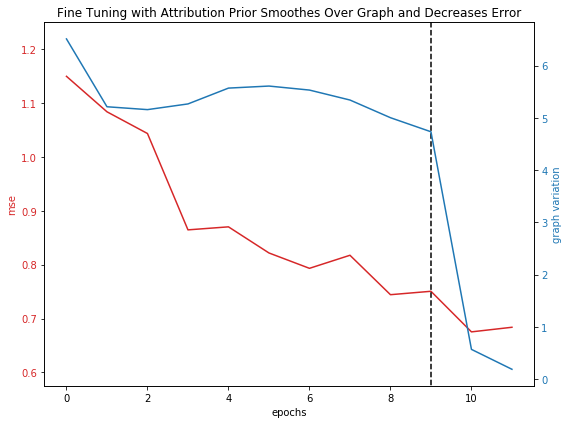

In [11]:
fig, ax1 = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('mse', color=color)
ax1.plot(np.arange(len(test_mse)), test_mse, color=color)
ax1.plot([training_epochs-1,training_epochs-1],[0,2],color='black',linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([np.amin(test_mse)-0.1,np.amax(test_mse)+0.1])

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('graph variation', color=color)  
ax2.plot(np.arange(len(test_mse)), graph_smoothness, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Fine Tuning with Attribution Prior Smoothes Over Graph and Decreases Error')

fig.tight_layout()
plt.show()

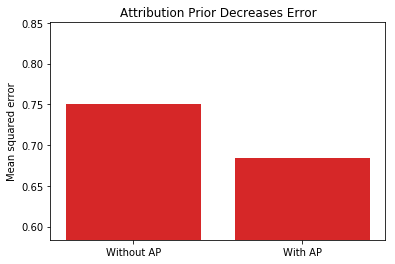

In [12]:
color = 'tab:red'
fig, axes = plt.subplots(1, 1)
ind_1 = training_epochs-1
ind_2 = training_epochs+fine_tuning_epochs-1
axes.bar([0,1],[test_mse[ind_1],test_mse[ind_2]],color=color)
axes.set_ylim([test_mse[ind_2]-0.1,test_mse[ind_1]+0.1])
xticks = [0,1]
axes.set_xticks(xticks)
axes.set_xticklabels(['Without AP','With AP'])
axes.set_ylabel('Mean squared error')
axes.set_title('Attribution Prior Decreases Error')
plt.show()

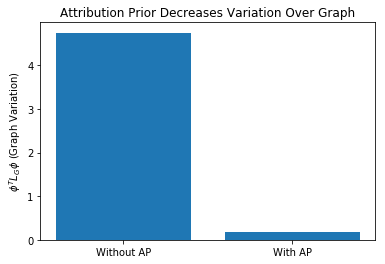

In [13]:
color = 'tab:blue'
fig, axes = plt.subplots(1, 1)
ind_1 = training_epochs-1
ind_2 = training_epochs+fine_tuning_epochs-1
axes.bar([0,1],[graph_smoothness[ind_1],graph_smoothness[ind_2]],color=color)
axes.set_ylim([0,graph_smoothness[ind_1]+0.25])
xticks = [0,1]
axes.set_xticks(xticks)
axes.set_xticklabels(['Without AP','With AP']);
axes.set_ylabel('$\phi^T L_G \phi$ (Graph Variation)')
axes.set_title('Attribution Prior Decreases Variation Over Graph')
plt.show()